In [1]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_utils
import RS_dataset
import RS_models

In [2]:
import logging
from pythonjsonlogger import jsonlogger

logger = logging.getLogger()

logHandler = logging.StreamHandler()
formatter = jsonlogger.JsonFormatter()
logHandler.setFormatter(formatter)
logger.addHandler(logHandler)

In [3]:
formatter = jsonlogger.JsonFormatter('%(one)s %(two)s')

In [4]:
formatter

In [5]:
#---
import os
import shutil

import numpy as np 
from glob import glob
import os
import torch
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
#---
import torch.nn as nn 
import datetime
import logging
import easydict

#-- data
img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

img_path_ship  = np.array(sorted(glob(os.path.join(img_path, "*.png"))) )
mask_path_ship = np.array(sorted(glob(os.path.join(mask_path, "*.png"))) )

aa = np.load("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/05.Training/Segmentation/03.data_list/512_ships.npy")

selected_paths_img = img_path_ship[aa]
selected_paths_mask  = mask_path_ship[aa]

#-- args
TASK = "EDGE"
MODEL_NAME = "EDGE_NET"
EXEC_VER = 62 
BATCH_SIZE = 4
DEVICE = "cuda:0"
DEVICES = [0,1,2,3]
RESUME = False
SAVE_EPOCH = 20

#-- category 
ISAID_CLASSES_SHIP = (
    'background','ship','harbor' 
    )
ISAID_PALETTE_SHIP = {
    0: (0, 0, 0), 
    1: (0, 0, 63), 
    2: (0, 100, 155)}


In [6]:
train_dataset = RS_dataset.Seg_RS_dataset_edge_v3(img_dir=selected_paths_img, mask_dir=selected_paths_mask, image_resize = None, phase="train",palette=ISAID_PALETTE_SHIP,gaussian=False,mask_onehot=False,softmax=False )

In [7]:
img, label, label_onehot, edge = train_dataset.__getitem__(0)

In [8]:
img.shape, label.shape, label_onehot.shape, edge.shape

(torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 256, 256]))

In [9]:
torch.unique(edge)

tensor([0, 1])

In [10]:
edge_onehot = RS_utils.apply_one_hot(edge,n_class=2)

In [11]:
edge_onehot.shape

torch.Size([1, 2, 256, 256])

In [12]:
DATA_SHUFFLE = True
train_dataset = RS_dataset.Seg_RS_dataset_edge_v4(img_dir=selected_paths_img, mask_dir=selected_paths_mask, image_resize = None, phase="train",palette=ISAID_PALETTE_SHIP)
dataloader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=DATA_SHUFFLE, collate_fn=train_dataset.collate_fn)

In [13]:
mask, edge = next(iter(dataloader))

In [14]:
mask.shape

torch.Size([4, 3, 256, 256])

In [15]:
edge.shape

torch.Size([4, 1, 256, 256])

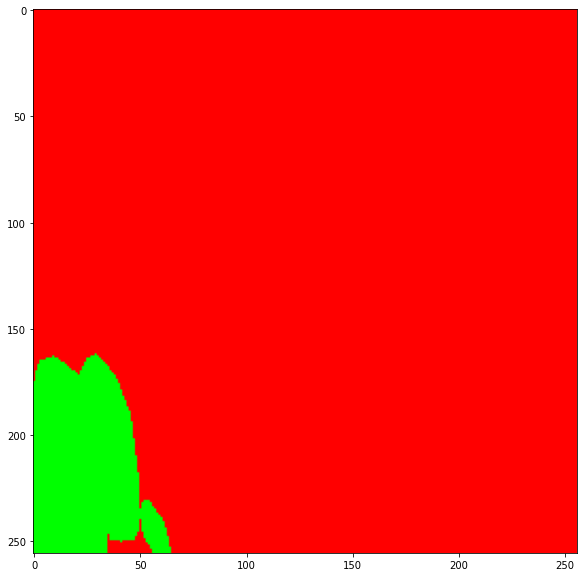

In [16]:
RS_utils.torch_display(mask[0])

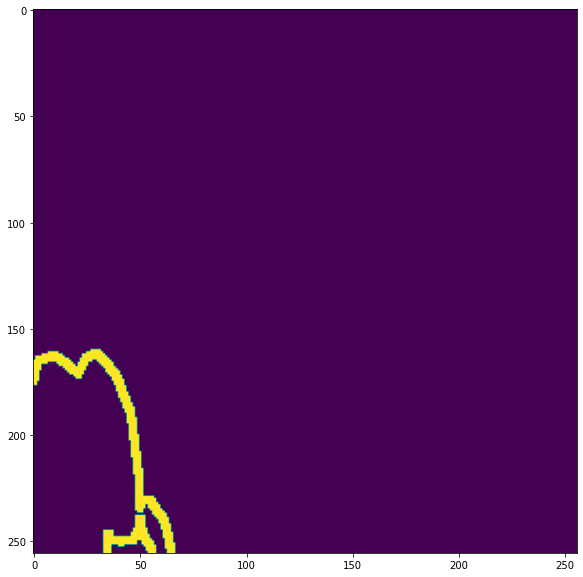

In [17]:
RS_utils.torch_display(edge[0])

In [18]:
edge_onehot.shape

torch.Size([1, 2, 256, 256])

In [19]:
shifted_x  = torch.roll(edge_onehot, shifts=1, dims=3)

In [20]:
shifted_x.shape

torch.Size([1, 2, 256, 256])

In [21]:
RS_utils.label_display(edge_onehot[0], n_class=2, nrows=1, ncols=2, channel_order='torch')

TypeError: label_display() missing 1 required positional argument: 'batch'

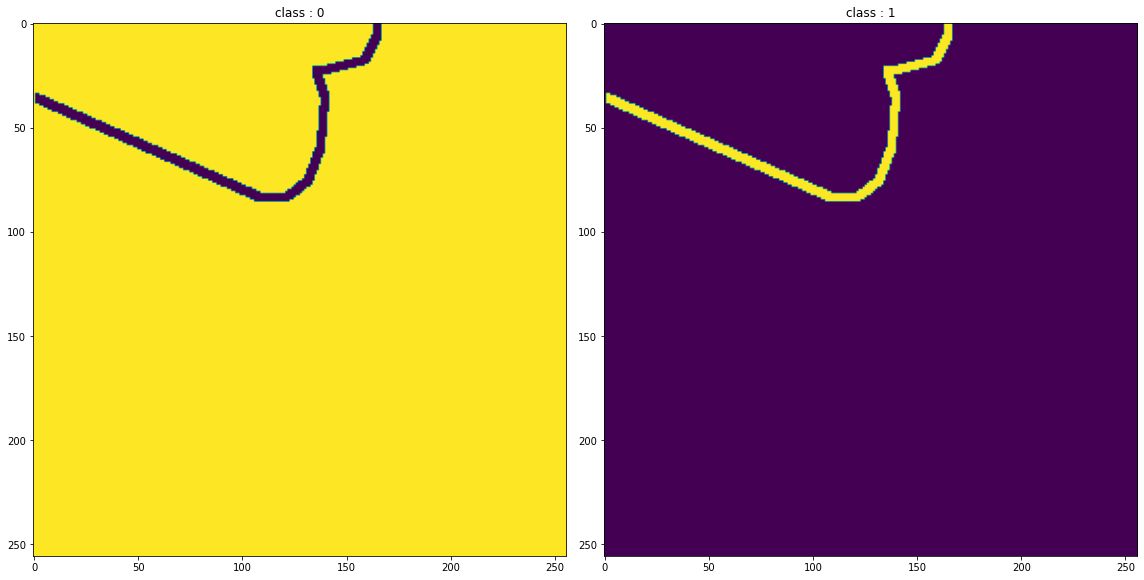

In [ ]:
RS_utils.label_display(shifted_x[0], n_class=2, nrows=1, ncols=2, channel_order='torch')

In [ ]:
edge_onehot.shape

torch.Size([4, 2, 256, 256])

In [ ]:
edge

In [ ]:
# input = input[:,1:,:,:]
# target = target[:,1:,:,:]
input  = edge_onehot[:,:,:,:]
target = shifted_x[:,:,:,:]

smooth = 1.

iflat = input.contiguous().view(-1)
tflat = target.contiguous().view(-1)
intersection = (iflat * tflat).sum()

nominator = (2. * intersection + smooth)
denominator =  (iflat.sum() + tflat.sum() + smooth)

rr  = nominator / denominator


In [ ]:
rr

tensor(0.9914)

In [ ]:
rr

tensor(1.)

In [ ]:
1 - 2. * intersection / (A_sum + B_sum)

tensor(0.)

In [ ]:
dice_ = RS_utils.dice_loss(edge_onehot, edge_onehot)

In [ ]:
dice_

tensor(0.)

In [ ]:
pred_onehot.shape

torch.Size([4, 2, 256, 256])

In [ ]:
edge_onehot.shape

torch.Size([4, 2, 256, 256])

In [ ]:
pred_onehot[0]

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

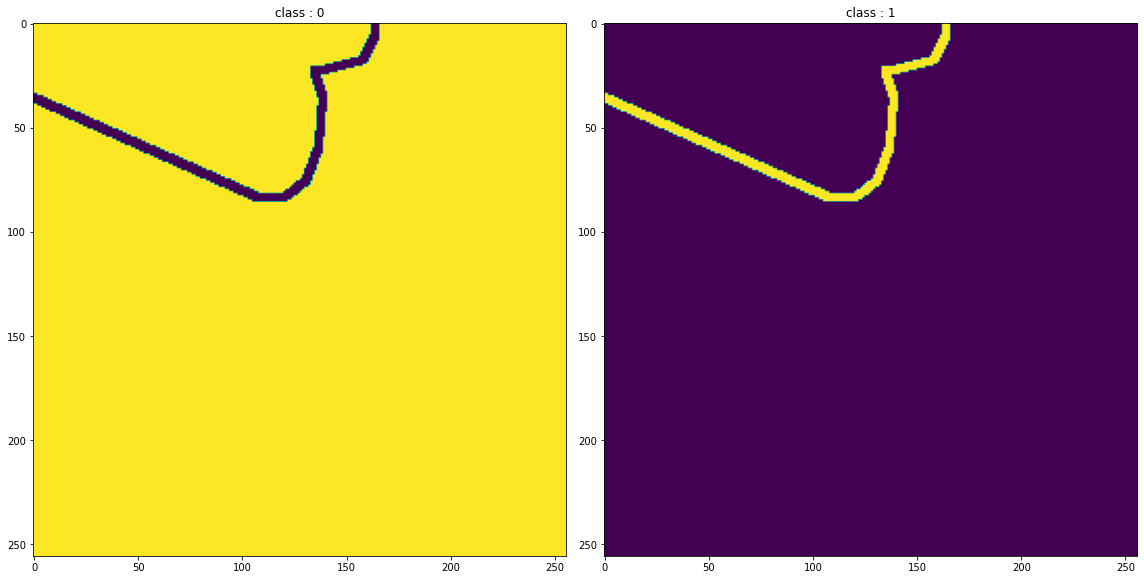

In [ ]:
RS_utils.label_display(label = pred_onehot[0], n_class=2, nrows=1,ncols=2,channel_order='torch')

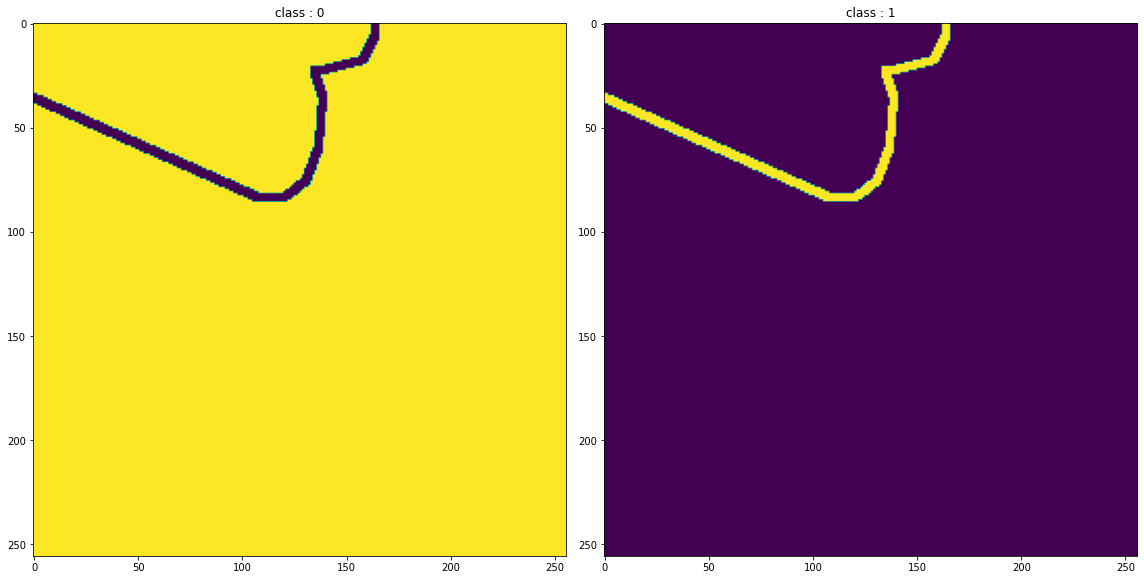

In [ ]:
RS_utils.label_display(label = edge_onehot[0], n_class=2, nrows=1,ncols=2,channel_order='torch')